In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
random.seed(50)

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# drop useless columns
data.drop('nameOrig',axis = 1,inplace = True)
data.drop('nameDest',axis = 1,inplace = True)
data.drop('isFlaggedFraud',axis = 1,inplace = True)

In [5]:
# convert TYPE list to onehotlabel
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(data[['type']])

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [6]:
# 0_CASH_IN 1_CASHOUT 2_DEBIT 3_PAYMENT 4_TRANSFER 
# first line means type is 3 payment
# third line means type is 4 transfer
ohe.categories_

[array(['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER'],
       dtype=object)]

In [7]:
typeonehot=ohe.fit_transform(data[['type']])

In [8]:
# X is preprocessing dataset
data_array = data.values
X=np.concatenate((data_array[:,0:1],typeonehot,data_array[:,2:]),axis=1)
X=pd.DataFrame(X)
X



,0,1,2,3,4,5,6,7,8,9,10,11
0,1,0.0,0.0,0.0,1.0,0.0,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,0.0,0.0,0.0,1.0,0.0,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,0.0,0.0,0.0,0.0,1.0,181.0,181.0,0.0,0.0,0.0,1
3,1,0.0,1.0,0.0,0.0,0.0,181.0,181.0,0.0,21182.0,0.0,1
4,1,0.0,0.0,0.0,1.0,0.0,11668.14,41554.0,29885.86,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,0.0,1.0,0.0,0.0,0.0,339682.13,339682.13,0.0,0.0,339682.13,1
6362616,743,0.0,0.0,0.0,0.0,1.0,6311409.28,6311409.28,0.0,0.0,0.0,1
6362617,743,0.0,1.0,0.0,0.0,0.0,6311409.28,6311409.28,0.0,68488.84,6379898.11,1
6362618,743,0.0,0.0,0.0,0.0,1.0,850002.52,850002.52,0.0,0.0,0.0,1


In [9]:
# select 10000 data randomly as training sample
sample_dataframe = X.sample(n=100000)
X = sample_dataframe.drop([11],axis = 1).iloc[:,:].values
y = sample_dataframe.iloc[:, 11].values

In [10]:
# transfer y label to 1d array,before is 2d array
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y

array([0, 0, 0, ..., 0, 0, 0])

In [11]:
# split the dataset to training set & test set
# X are features    y are labels
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)



In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import RandomOverSampler

In [13]:
# training train data X_train
pipe_lr = make_pipeline(LinearSVC(random_state=1))
pipe_lr.fit(X_train, y_train)
print('Test accuracy: %.3f' % pipe_lr.score(X_test, y_test))

Test accuracy: 0.997


/Users/shiki/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [14]:
# make prediction to Test data by using training model
y_pre = pipe_lr.predict(X_test)

In [15]:
# confusion matrix
from sklearn.metrics import confusion_matrix
print('confusion_matrix\n',confusion_matrix(y_test.astype(int).astype(str),y_pre.astype(str)))



confusion_matrix
 [[19921    54]
 [   16     9]]


In [16]:
y_test.astype(int).astype(str)

array(['0', '0', '0', ..., '0', '0', '0'], dtype='<U21')

In [17]:
y_pre.astype(str)

array(['0', '0', '0', ..., '0', '0', '0'], dtype='<U21')

In [18]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc  
fpr,tpr,threshold = roc_curve(y_test, y_pre)
roc_auc = auc(fpr,tpr) 

In [19]:
# roc value
roc_auc

0.6786483103879849

<Figure size 432x288 with 0 Axes>

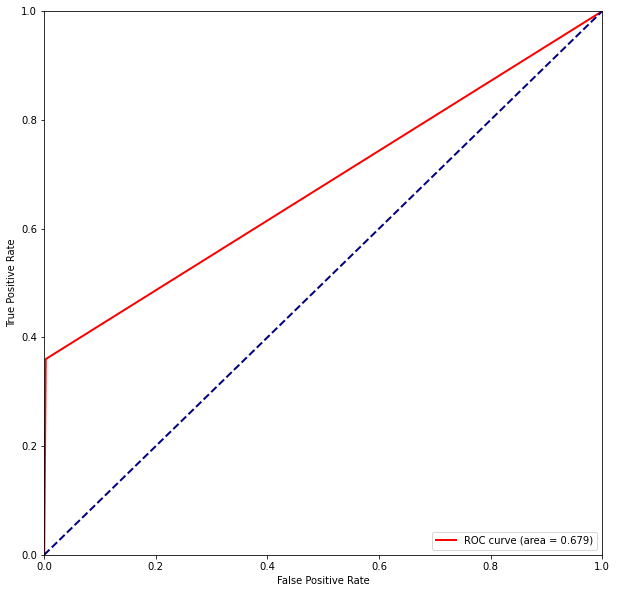

In [20]:
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='r',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc="lower right")
plt.show()

In [21]:
from sklearn.metrics import confusion_matrix, classification_report

In [22]:
print(classification_report(y_test,y_pre))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19975
           1       0.14      0.36      0.20        25

    accuracy                           1.00     20000
   macro avg       0.57      0.68      0.60     20000
weighted avg       1.00      1.00      1.00     20000

